In [1]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from weighted_model.fair_teacher_student_classifier import FairTeacherStudentClassifier
from weighted_model.teacher_student_classifier import TeacherStudentClassifier
from curriculum_models.curriculum_student_teacher import CurriculumStudentTeacher
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility

In [2]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


race                class
Amer-Indian-Eskimo  <=50K    0.882979
                    >50K     0.117021
Asian-Pac-Islander  <=50K    0.730744
                    >50K     0.269256
Black               <=50K    0.879189
                    >50K     0.120811
Other               <=50K    0.876847
                    >50K     0.123153
White               <=50K    0.746013
                    >50K     0.253987
Name: proportion, dtype: float64


C:\Users\trdin\AppData\Local\Temp\ipykernel_12672\2974537177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('race')['class'].value_counts(normalize=True))


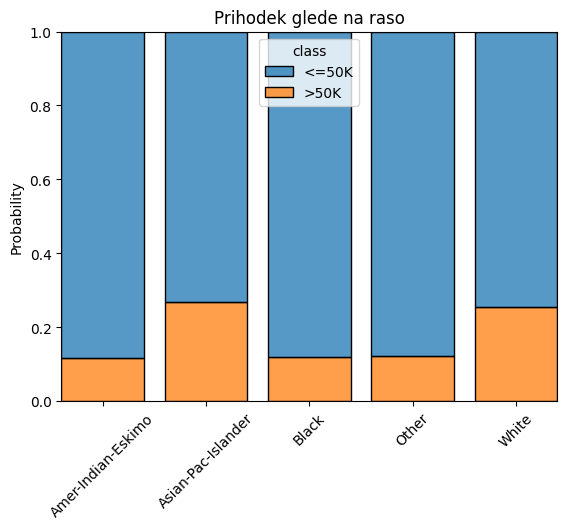

In [3]:
import matplotlib.pyplot as plt
print(df.groupby('race')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na raso")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [4]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Train-test split
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y)


In [5]:

def split_into_parts(X, y_prob, n_splits = 5):
    """Splits X and y into 5 equal parts and returns them as a list of (X_part, y_part)."""
    split_size = len(X) // n_splits
    
    # Convert probabilities to predictions
    y_pred = np.argmax(y_prob, axis=1)

    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X)
        split_data.append((X[start_idx:end_idx], y_pred[start_idx:end_idx]))

    return split_data


In [6]:
import numpy as np
import pandas as pd

def split_into_difficulty_parts(X, y_prob, n_splits=5):
    """Splits X and y into 5 parts based on the highest prediction probability, 
    with the most difficult samples (lowest probability) getting split last.
    """
    split_size = len(X) // n_splits
    
    # Get the maximum probability and corresponding predicted class
    max_prob = np.max(y_prob, axis=1)  # Get highest probability for each sample
    y_pred = np.argmax(y_prob, axis=1)  # Get predicted class labels

    # Combine X (DataFrame), y_pred, and max_prob into a single DataFrame for sorting
    X_sorted = X.copy()  # Work with a copy to avoid modifying original
    X_sorted['y_pred'] = y_pred
    X_sorted['max_prob'] = max_prob
    
    # Sort by the highest probability (descending order) - more confident predictions come first
    X_sorted = X_sorted.sort_values(by='max_prob', ascending=False)

    #print(X_sorted.head())    
    # Split the sorted data into n_splits parts
    split_data = []
    for i in range(n_splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < n_splits - 1 else len(X_sorted)
        split_X = X_sorted.iloc[start_idx:end_idx].drop(columns=['y_pred', 'max_prob'])  # Drop auxiliary columns
        #print(split_X.head())
        split_y_pred = X_sorted.iloc[start_idx:end_idx]['y_pred']
        split_data.append((split_X, split_y_pred))

    return split_data


In [12]:

curriculum_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_parts, split_data=True, n_splits=6)	

difficulty_based_model = CurriculumStudentTeacher(teacher_type=RandomForestClassifier, student_type = SGDClassifier, transform_func= split_into_difficulty_parts, split_data=True, n_splits=6)



#Student Teacher models for reference
baseline_model = TeacherStudentClassifier(RandomForestClassifier, split_data=True)

baseline_split = TeacherStudentClassifier(RandomForestClassifier, split_data=True)

#randomForrest for reference
rf_classifier = RandomForestClassifier()

# Train classifiers
baseline_model.fit(X_train, y_train)
difficulty_based_model.fit(X_train, y_train)
curriculum_model.fit(X_train, y_train)
baseline_split.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

# Predicitons with all the models 

curriculum_model_predictions = curriculum_model.predict(X_test)
difficulty_based_model_predictions = difficulty_based_model.predict(X_test)

baseline_model_predictions= baseline_model.predict(X_test)
baseline_split_predictions = baseline_split.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

{'Difficulty Based Model': 0.7838059166751971, 'Curriculum Model': 0.7860579383764971, 'Baseline Model': 0.8618077592384072, 'Baseline Split': 0.8613983007472618, 'Random Forest': 0.8588391851776026}


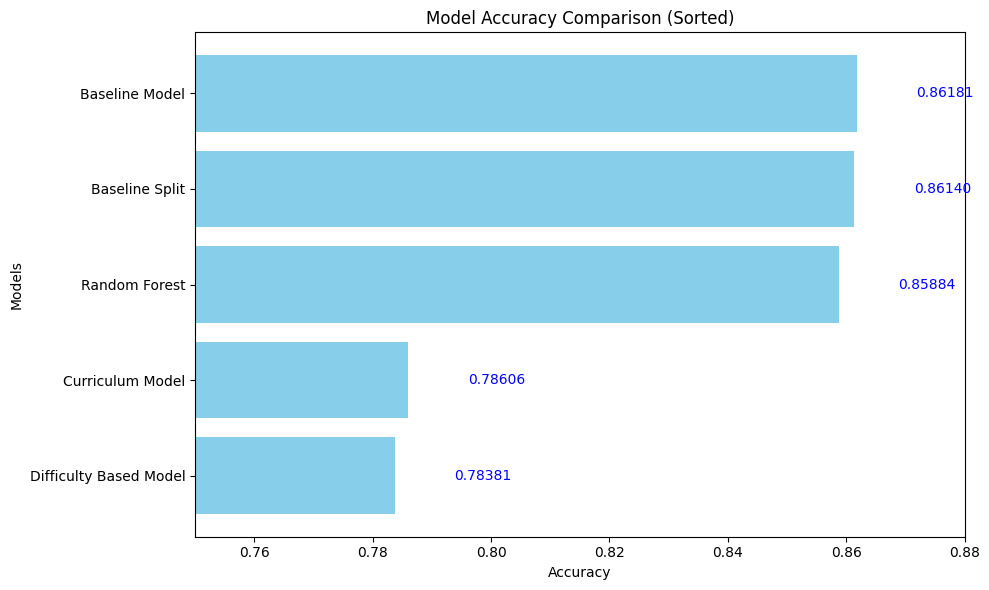

In [13]:
# Evaluate accuracy for each model
accuracies = {
    "Difficulty Based Model": accuracy_score(y_test, difficulty_based_model_predictions),
    "Curriculum Model": accuracy_score(y_test, curriculum_model_predictions),
    "Baseline Model": accuracy_score(y_test, baseline_model_predictions),
    "Baseline Split": accuracy_score(y_test, baseline_split_predictions),
    "Random Forest": accuracy_score(y_test, rf_predictions),
}

print(accuracies)

# Sort models by accuracy
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
models = [item[0] for item in sorted_accuracies]
accuracy_values = [item[1] for item in sorted_accuracies]

# Plot the sorted accuracies
plt.figure(figsize=(10, 6))
plt.barh(models, accuracy_values, color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.title("Model Accuracy Comparison (Sorted)")
plt.gca().invert_yaxis()  # Invert y-axis to show highest accuracy at the top
plt.xlim(0.75, 0.88)


# Annotate bars with accuracy values
for i, v in enumerate(accuracy_values):
    plt.text(v + 0.01, i, f"{v:.5f}", color='blue', va='center')

plt.tight_layout()
plt.show()
